In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import xlrd
import time

In [2]:
import csv
def csv_reader(path):
    with open(path, 'r', encoding='utf-8') as fp:
        reader = csv.reader(fp)
        data = [i for i in reader]
    return data
def csv_writer(path, header, data):
    with open(path, 'w', encoding='utf-8', newline="") as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(header)
        writer.writerows(data)

In [3]:
# start processing
# df = pd.read_excel('./PASSENGER_RECORD.xlsx')
# # convert .xlsx file to .csv file for easy loading. Simply use MS Excel 'save as' function. 
df = pd.read_csv('./data/PASSENGER_RECORD.csv')

In [4]:
df.columns

Index(['PR_ID', 'PPID', 'TRAIN_TYPE', 'TRAIN_CODE', 'BOARD_DATE', 'BOARD_TIME',
       'ARRIVAL_DATE', 'ARRIVAL_TIME', 'START_STA', 'ARRIVAL_STA',
       'TRAVEL_TIME', 'TRAVEL_LENGTH', 'SEAT_TYPE', 'COACH_NO', 'SEAT_NO',
       'BUYYER_PID'],
      dtype='object')

BOARD_DATE、BOARD_TIME日期和时间是分离的，把它们合并到同一列上，ARRIVAL同理

In [5]:
# this code is not compatible  with the csv reader
# df['BOARD_TIME'] = df['BOARD_DATE'] + df['BOARD_TIME'].apply(str).apply(pd.Timedelta)
# df = df.drop(['BOARD_DATE'], axis=1)
# df['BOARD_TIME']

In [6]:
# # this code is not complatible with csv reader
# # ARRIVAL虽然看上去和BOARD一样，但实际上读取到的类型是datetime.time，所以做一个特殊的parser来处理，不能直接apply(str)
# parser = lambda time : time.strftime('%H:%M:%S')
# df['ARRIVAL_TIME'] = df['ARRIVAL_DATE'] + df['ARRIVAL_TIME'].apply(parser).apply(pd.Timedelta)
# df = df.drop(['ARRIVAL_DATE'], axis=1)
# df['ARRIVAL_TIME']

In [7]:
# df['BOARD_TIME'].max() - df['BOARD_TIME'].min()

数据为11076名乘客一年内的购票记录

In [8]:
df.groupby('PPID')['TRAVEL_LENGTH'].describe()

,count,mean,std,min,25%,50%,75%,max
PPID,,,,,,,,
1.10103E+17,56.0,670.714286,746.941198,0.0,89.00,268.5,1209.75,2343.0
1.10105E+17,50.0,662.000000,397.694068,40.0,269.50,738.0,964.00,1241.0
1.10108E+17,45.0,580.288889,408.452268,0.0,300.00,499.0,796.00,1408.0
1.10222E+17,426.0,175.469484,132.810773,19.0,154.00,154.0,154.00,2420.0
1.10224E+17,497.0,240.557344,269.112357,13.0,154.00,154.0,154.00,1691.0
...,...,...,...,...,...,...,...,...
65312419920615332X,43.0,281.395349,273.697708,0.0,6.00,266.0,426.00,1428.0
65412119900226066X,614.0,132.724756,141.314434,0.0,65.00,123.0,140.00,1537.0
65412319911204248X,56.0,331.625000,237.186659,3.0,138.75,299.0,472.75,946.0


<AxesSubplot:>

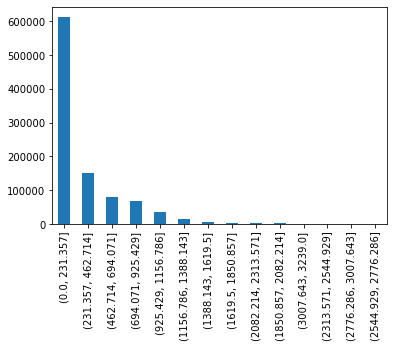

In [9]:
bins = np.linspace(df['TRAVEL_LENGTH'].min(), df['TRAVEL_LENGTH'].max(), 15)
travel_length_cat = pd.cut(df['TRAVEL_LENGTH'], bins)
travel_length_cat.value_counts().plot(kind='bar')

### Highlights
- 出发站、到达站的填充：可以用列车编号、到达站（出发站）、运行时间完全相同的数据来填充
- 百度地图API转经纬度
- DBSCAN Isolation Forest

### Features to be preprocessed
- 乘车时间间隔（设置阈值划分长途和短途）
- 乘车频率（可以按月统计）
- Num of boarding stations（可以看最常去的所占的比例）
- 夜间乘车次数
- 座位种类

In [10]:
# ['PR_ID', 'PPID'1, 'TRAIN_TYPE'1, 'TRAIN_CODE'1, 'BOARD_DATE', 'BOARD_TIME',
#        'ARRIVAL_DATE', 'ARRIVAL_TIME', 'START_STA'1, 'ARRIVAL_STA'1,
#        'TRAVEL_TIME', 'TRAVEL_LENGTH', 'SEAT_TYPE'1, 'COACH_NO', 'SEAT_NO',
#        'BUYYER_PID'1]

# Simple token features we use in our project are:
1. Passenger. PPID
    - Format: a integer indicates passenger id
2. Buyyer. BUYYER_PID
    - Format: a integer indicates buyyer id
3. Start Stations.  START_STA
    - Format: a integer indicates No. of Start Station
4. Arrival Stations.  ARRIVAL_STA
    - Format: a integer indicates No. of Arrival Station
5. Train Code. TRAIN_CODE
    - Format: a integer
6. Train Type. TRAIN_TYPE
    - Format: a integer
7. Seat type. SEAT_TYPE
    - Format: a integer 


In [11]:
simple_feature2idx = {'PPID':{},
                      'BUYYER_PID':{}, 
                      'START_STA':{}, 
                      'ARRIVAL_STA':{}, 
                      'TRAIN_CODE':{}, 
                      'TRAIN_TYPE':{}, 
                      'SEAT_TYPE':{}}

In [12]:
# set look-up table
for feature in simple_feature2idx.keys():
    print("processing: {}".format(feature))
    df[feature] = df[feature].apply(str)
    for value in df[feature].apply(str).tolist():
        if value not in simple_feature2idx[feature]:
            simple_feature2idx[feature][value] = len(simple_feature2idx[feature])

processing: PPID
processing: BUYYER_PID
processing: START_STA
processing: ARRIVAL_STA
processing: TRAIN_CODE
processing: TRAIN_TYPE
processing: SEAT_TYPE


In [13]:
def tokenize_feature(all_features, feature2idx):
    index_list = [feature2idx[feat] for feat in all_features] 
    feature_vector = np.array(index_list)
    print(feature_vector.shape)
    return feature_vector

In [14]:
# set look-up table
simple_feature_vectors = {}
for feature in simple_feature2idx.keys():
    simple_feature_vectors[feature] = tokenize_feature(df[feature].apply(str).tolist(), simple_feature2idx[feature])

(985759,)
(985759,)
(985759,)
(985759,)
(985759,)
(985759,)
(985759,)


# Simple digit features we use in our project are:
1. Tranvel Time. TRAVEL_TIME
    - Format: a integer represent hours   
1. Tranvel Length. TRAVEL_LENGTH
    - Format: a integer represent distances   
3. Board Date.  BOARD_DATE
    - Format: a integer represent num of days after 2012/01/01 when boarding. 比如2012年1月2号就是1，2月15日就是30+15=45
4. Board Time. BOARD_TIME
    - Format: a interger represent num minutes from 0:0:0. 比如当日4点15分就是4*60+15=255
5. Arrival Date.  ARRIVAL_DATE
    - Format: a integer represent num of days after 2012/01/01 when boarding. 比如2012年1月2号就是1，2月15日就是30+15=45
6. Arrival Time.  ARRIVAL_TIME
    - Format: a interger represent num minutes from 0:0:0. 比如当日4点15分就是4*60+15=255
7. Seat Number.  SEAT_NO
    - Format: a integer 
8. Coach Number.  COACH_NO
    - Format: a integer 


In [15]:
digit_feature2idx = {'TRAVEL_TIME':{},
                     'TRAVEL_LENGTH':{},
                     'BOARD_DATE':{}, 
                     'BOARD_TIME':{}, 
                     'ARRIVAL_DATE':{}, 
                     'ARRIVAL_TIME':{}, 
                     'SEAT_NO':{}, 
                     'COACH_NO':{}}

In [16]:
digit_feature_vectors = {}
for feature in digit_feature2idx.keys():
    if feature in ['TRAVEL_LENGTH', 'SEAT_NO', 'COACH_NO']:
        index_list = df[feature].apply(int).tolist()
        feature_vector = np.array(index_list)
        print("{}\t{}".format(feature, feature_vector.shape))
        digit_feature_vectors[feature] = feature_vector

TRAVEL_LENGTH	(985759,)
SEAT_NO	(985759,)
COACH_NO	(985759,)


In [17]:
feature_vector = np.array([int(item.split(':')[0]) for item in df['TRAVEL_TIME'].apply(str).tolist()])
print("{}\t{}".format('TRAVEL_TIME', feature_vector.shape))
digit_feature_vectors['TRAVEL_TIME'] = feature_vector

TRAVEL_TIME	(985759,)


In [19]:
# board_times = pd.to_datetime((df['BOARD_DATE'] +' ' + df['BOARD_TIME'].apply(str)), format='%m/%d/%Y %H:%M:%S')
board_times = pd.to_datetime((df['BOARD_DATE'] +' ' + df['BOARD_TIME'].apply(str)), format='%Y/%m/%d %H:%M:%S')
for row_idx, item in enumerate(df['ARRIVAL_TIME'].apply(str).tolist()):
    if item[:2]=='25' or item[:2]=='24':
        df['ARRIVAL_TIME'][row_idx] = '23'+item[2:]
# arrival_times = pd.to_datetime((df['ARRIVAL_DATE'] +' ' + df['ARRIVAL_TIME'].apply(str)), format='%m/%d/%Y %H:%M:%S')
arrival_times = pd.to_datetime((df['ARRIVAL_DATE'] +' ' + df['ARRIVAL_TIME'].apply(str)), format='%Y/%m/%d %H:%M:%S')
initial_timestamp = pd.Timestamp('2012-01-01T00')  # Timestamp('2012-01-01 00:00:00')

feature_vector = np.array((board_times - initial_timestamp).astype('timedelta64[D]').tolist())
print("{}\t{}".format('BOARD_DATE', feature_vector.shape))
digit_feature_vectors['BOARD_DATE'] = feature_vector

feature_vector = np.array([h*60+m for h, m in zip(board_times.dt.hour.tolist(), board_times.dt.minute.tolist())])
print("{}\t{}".format('BOARD_TIME', feature_vector.shape))
digit_feature_vectors['BOARD_TIME'] = feature_vector

feature_vector = np.array((arrival_times - initial_timestamp).astype('timedelta64[D]').tolist())
print("{}\t{}".format('ARRIVAL_DATE', feature_vector.shape))
digit_feature_vectors['ARRIVAL_DATE'] = feature_vector

feature_vector = np.array([h*60+m for h, m in zip(arrival_times.dt.hour.tolist(), arrival_times.dt.minute.tolist())])
print("{}\t{}".format('ARRIVAL_TIME', feature_vector.shape))
digit_feature_vectors['ARRIVAL_TIME'] = feature_vector


ValueError: time data '2012/3/8 19:04:00' does not match format '%Y%m/%d %H:%M:%S' (match)

# Advanced features we use in our project are 
6. Buyyer is the same with Passenger? BUYYER_PID/PPID  new: SAME_PERSON  
    - Format: a integer 1 or 0

In [12]:
advanced_feature_vectors = {}


In [16]:
all_feature_vectors = np.stack(list(simple_feature_vectors.values()) + 
                               list(digit_feature_vectors.values()) + 
                               list(advanced_feature_vectors.values()), axis=0)
print(all_feature_vectors.shape)

(15, 985759)
